In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
my_local_drive='/content/gdrive/MyDrive/ML2_projet'
sys.path.append(my_local_drive)

In [ ]:
%cd $my_local_drive

/content/gdrive/MyDrive/ML2_projet


In [ ]:
import os
import pandas as pd
import re
import numpy as np
import random
import zipfile
import requests
import io
import math
from pathlib import Path
import datetime

from dataclasses import dataclass

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.metrics import Mean
from tensorflow.keras.layers import Dropout, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

# Pour utiliser au mieux le GPU
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# Tensorboard initialisation
# %load_ext tensorboard
# log_dir = my_local_drive + "/logs/" + datetime.datetime.now().strftime("%d-%m-%Y-%H%M%S")
# os.makedirs(log_dir, exist_ok=True)
# sys.path.append(log_dir)
# %tensorboard --logdir $log_dir
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# Classes à utiliser pour la partie classification de texte. Laquelle ?
  ## --> pratique si on récupère le premier token 'CLS' style
@register_keras_serializable()
class SelectFirstToken (layers.Layer):
  # Retourne le premier mot
    def call(self, inputs):
        return inputs[:, 0] # (batch, embed_dim)

@register_keras_serializable()
class SelectMean(layers.Layer):
  # Retourne la moyenne des mots - bien si pas trop de PAD - chaînes même taille
    def call(self, inputs):
        # inputs: (batch, seq_len, embed_dim)
        return tf.reduce_mean(inputs, axis=1)  # (batch, embed_dim)


@register_keras_serializable()
class MaskedMean(layers.Layer):
  # Retourne la moyenne des mots sans être trop influencé par PAD
    def call(self, inputs):
        seq_out, token_ids = inputs   # (B,L,D), (B,L)
        mask = tf.cast(tf.not_equal(token_ids, 0), seq_out.dtype)  # PAD=0
        mask = tf.expand_dims(mask, -1)        # (B,L,1)
        summed = tf.reduce_sum(seq_out * mask, axis=1)             # (B,D)
        counts = tf.reduce_sum(mask, axis=1)                        # (B,1)
        return summed / tf.maximum(counts, 1.0)


# Classe utile pour la partie Clip mais il fallait bien regarder pour la trouver
@register_keras_serializable()
class L2Normalize(layers.Layer):
    def __init__(self, axis=-1, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)

    def get_config(self):
        config = super().get_config()
        config.update({"axis": self.axis})
        return config

# PARTIE SMALL_BERT = COPIE DU NOTEBOOK
# ============================
# PositionalEmbedding Layer
# ============================
@tf.keras.utils.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size,
                                                 output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length,
                                                    output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(0, length)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

# ============================
# TransformerBlock
# ============================
@tf.keras.utils.register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads,ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False, mask=None):
        seq_len = tf.shape(inputs)[1]
        attn_mask = None
        if mask is not None:
            attn_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.float32)
            attn_mask = tf.tile(attn_mask, [1, seq_len, 1])

        attn_output = self.att(inputs, inputs, inputs, attention_mask=attn_mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

        def get_config(self):
            config = super().get_config()
            config.update({
                "embed_dim": self.att.key_dim,
                "num_heads": self.att.num_heads,
                "ff_dim": self.ffn.layers[0].units,
                "dropout_rate": self.dropout1.rate,
            })
            return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# ============================
# SmallBERT encoder
# ============================
@register_keras_serializable()
class SmallBERT(tf.keras.Model):
    def __init__(self, sequence_length, vocab_size, embed_dim, num_heads,
                 ff_dim, num_layers, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(sequence_length, vocab_size,
                                                 embed_dim)

        self.transformer_blocks = [
              TransformerBlock(embed_dim,
                             num_heads, ff_dim) for _ in range(num_layers)
        ]
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout = tf.keras.layers.Dropout(0.1)

    def call(self, inputs, training=False):
        x = self.pos_embedding(inputs)
        for block in self.transformer_blocks:
            x = block(x, training=training)
        x = self.layernorm(x)
        return self.dropout(x, training=training)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "num_layers": self.num_layers,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [ ]:
# Perte contrastive CLIP
# Le but de cette fonction est d’aligner les embeddings d’images et de textes
# correspondants dans un espace latent partgé. Elle est inspirée du papier
# CLIP, où l'on entraîne le modèle à prédire quelle image correspond à quel
# texte et réciproquement.

@register_keras_serializable(package="clip")
class ClipLossLayer(layers.Layer):
    def __init__(self, temperature=0.07, **kwargs):
        super().__init__(**kwargs)
        self.temperature = temperature
        self.clip_loss_metric = tf.keras.metrics.Mean(name="clip_loss")

    def call(self, inputs):
        # l'inputs est forcément (img, txt) ou [img, txt]
        img, txt = inputs  # (B, D) attention il faut avoir L2-normalisés !!

        # Matrice des similarités (cosinus parce qu'on a L2 zt ça simplifie)
        logits = tf.matmul(img, txt, transpose_b=True) / self.temperature

        # Les Labels implicites : c'est la diagonale
        labels = tf.range(tf.shape(logits)[0])

        li = tf.keras.losses.sparse_categorical_crossentropy(labels,
                                                             logits,
                                                             from_logits=True)
        lt = tf.keras.losses.sparse_categorical_crossentropy(labels,
                                                          tf.transpose(logits),
                                                          from_logits=True)
        loss = tf.reduce_mean(li + lt) / 2.0

        # Ca c'est super important car on ajoute la loss au graphe
        # du modèle et ça nous simplifie la vie
        # après on met à jour la métrique interne si on veut la suivre
        self.add_loss(loss)
        self.clip_loss_metric.update_state(loss)

        # On retourne un TUPLE de tenseurs(surtout pas une liste)
        # dc facileà récupérer
        return (img, txt)

    def get_config(self):
        return {**super().get_config(), "temperature": self.temperature}


In [ ]:
def plot_history_simple(history):
    """
    Trace côte à côte les courbes Loss et Accuracy (train/val si dispo)
    à partir d'un objet Keras History.
    """
    hist = history.history

    # compatibilité anciennes versions ("acc"/"val_acc")
    acc_key = "accuracy" if "accuracy" in hist else "acc"
    val_acc_key = "val_accuracy" if "val_accuracy" in hist else "val_acc"

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # --- Loss ---
    if "loss" in hist:
        axes[0].plot(hist["loss"], label="train")
    if "val_loss" in hist:
        axes[0].plot(hist["val_loss"], label="val")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # --- Accuracy ---
    if acc_key in hist:
        axes[1].plot(hist[acc_key], label="train")
        if val_acc_key in hist:
            axes[1].plot(hist[val_acc_key], label="val")
        axes[1].set_title("Accuracy")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Accuracy")
        axes[1].legend()
    else:
        axes[1].set_visible(False)  # si pas d'accuracy, on masque le 2e plot

    plt.tight_layout()
    plt.show()


In [ ]:
# Répertoire cible pour sauvegarder vos modèles
model_dir = "./models_forclip"
os.makedirs(model_dir, exist_ok=True)
# Répertoire des données
dataset_dir = "./flickr_subset2"
train_dir = os.path.join(dataset_dir, "train_data")
# Répertoire des images
image_dir = os.path.join(train_dir, "images")
# Répertoire des captions
captions_dir = os.path.join(train_dir, "captions")

# caption_path
captions_csv_path = os.path.join(train_dir, "captions.csv")

# token form train dataset
vocab_path = os.path.join(dataset_dir, "vocab.txt")

# Variables utiles
# Attention respecter bien l'ordre alphabétique des classes pour
# le générateur
class_names = ['ball', 'bike', 'dog', 'water']
# class encoding dict
class_dict = {
    "ball": 0,
    "bike": 1,
    "dog": 2,
    "water": 3
}
# Pour les images
image_size=(224, 224)
image_shape = image_size + (3,)


# Pour les textes
sequence_length = 32
vocab_size = 10000
num_heads = 4
ff_dim = 256
num_layers = 2

# Pour les images et les textes dans le modèle CLIP
embed_dim = 128

# pour le training:
batch_size = 16

# DATA LOADER

In [ ]:
def make_clip_dataset_smallbert(
    captions_csv_path,
    tokenizer_layer,
    batch_size=16,
    shuffle=True,
    drop_remainder=True,
    cache=True,
    seed=42,
):
    """
    Construit un tf.data.Dataset avec en sortie (images, token_ids) pour CLIP.
    """
    # On récupère le fichier captions.csv qui a tout
    df = pd.read_csv(captions_csv_path)
    image_paths = df["image_path"].astype(str).tolist()
    captions    = df["caption"].fillna("").astype(str).tolist()

    # Récupération du répertoire des images
    root = Path(dataset_dir)
    full_paths = [str(root / p) for p in image_paths]

    # Création du dataset d'image
    ds = tf.data.Dataset.from_tensor_slices((full_paths, captions))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(full_paths), seed=seed,
                        reshuffle_each_iteration=True)

    # Chargement d'une ensemble d'images normalisées et de tokens (le texte)
    IMAGE_H, IMAGE_W = 224, 224  # même que image_size

    def load_sample(img_path, caption):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [224, 224])
        img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
        tokens = tf.cast(tokenizer_layer(caption), tf.int32)  # (L,)
        # x = dict des 2 entrées, pour forcer à ne pas avoir de  y
        return {"image_input": img, "text_input": tokens}


    # Pour utiliser le cache et pouvoir faire les traitements en //
    ds = ds.map(load_sample, num_parallel_calls=AUTOTUNE)
    if cache:
        ds = ds.cache()
    # si drop_remainder=True on vire le dernier batch
    # s'il n'est pas de la bonne taille
    ds = ds.batch(batch_size, drop_remainder=drop_remainder).prefetch(AUTOTUNE)
    return ds

# Quanq le tokenizer est initialisé, un exemple d'appel que vous pourrez faire :
# train_dataset = make_clip_dataset_smallbert(captions_csv_path,
#                                       text_tokenizer,
#                                       batch_size=64)

# Tokenizer adapting

In [ ]:
# Create a token list file (one token per row)
# Generate tokens on trian dataset only
# def generate_token_file(tokenizer, train_ds, token_file_path:str, overwrite=False):
#   if os.path.exists(token_file_path) and not overwrite:
#     print(f"token file already exist, skipping adapting: {token_file_path}")
#     return
#   else:
#     print(f"generating token file: {token_file_path}")
#     tokenizer.adapt()
#     with open(token_file_path, "w"):

# MODEL BUILDING

In [ ]:
def build_clip_classifier(
    sequence_length,
    vocab_size,
    embed_dim,
    num_attention_heads,
    ff_dim,
    num_layers,
    vocabulary,  # Vocabulary from a preadapted textvectorizer for text encoding
    nb_image_filters=32,
    training: bool=False,
    pad_sequence: bool=True):

import csv

def save_history_csv(history, filename):
    """Save tf.keras History object to a CSV file."""
    hist_dict = history.history
    keys = hist_dict.keys()
    rows = zip(*hist_dict.values())

    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(keys)
        writer.writerows(rows)
  print("start building model")
  #### Part 1: Text encoding
  ## Text inputs (need layer name to match tf.dataset keys)
  ## Text inputs are already tokenized
  text_inputs = layers.Input(shape=(sequence_length,), dtype=tf.int32, name="text_input")

  ## smallBertEncoding
  # attention mask will be determined by the bert model
  base_model = SmallBERT(
      sequence_length=sequence_length,
      vocab_size=vocab_size,
      embed_dim=embed_dim,
      num_heads=num_attention_heads,
      ff_dim=ff_dim,
      num_layers=num_layers
  )(text_inputs)

  ## Final vector representation
  # how to compress information to a single vector
  # text_vector = MaskedMean()((base_model, text_inputs))
  text_vector = MaskedMean()((base_model, text_inputs))

  # normalize
  norm_text_vector = L2Normalize(name="text_latent_vector")(text_vector)

  print("start building image model")
  #### Part 2: Image encoding
  ## Image inputs (need layer name to match tf.dataset keys)
  image_inputs = tf.keras.Input(shape=(224, 224, 3), name='image_input')

  ## Image processing
  rescaling_layer = Rescaling(1./255)(image_inputs)

  ## data augmentation (Sequential layer here ?)

  ## CNN encoding
  convolution_layer = Conv2D(
      filters=nb_image_filters,
      kernel_size=3,
      activation="relu")(rescaling_layer)
  max_pooling_layer = MaxPooling2D(pool_size=(2, 2))(convolution_layer)
  flatten_layer = Flatten()(max_pooling_layer)
  ## set image latent space size equal to text latent space size
  image_vector = Dense(embed_dim,
                       activation="relu")(flatten_layer)

  ## Normalize
  norm_image_vector = L2Normalize(name="image_latent_vector")(image_vector)


  ##### CLIP part
  print("start building clip part")
  ## Compute clip distance
  clip_layer = ClipLossLayer(name="clip_loss_layer")([norm_image_vector, norm_text_vector])

  ##### Final part: build model
  print("build full model")
  # final model
  final_model = keras.Model(inputs=[image_inputs, text_inputs], outputs=clip_layer, name="clip_training")
  final_model.summary()
  print("compile")
  # No loss in compile, it's in the model --> I AM BLIND THIS WAS THE ANSWER ALL ALONG..
  final_model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-4)
    )
  return final_model

# PIPELINE

In [ ]:
# Build and train model
model_config = {
    "sequence_length":sequence_length,
    "vocab_size":vocab_size,
    "embed_dim":embed_dim,
    "num_attention_heads":num_heads,
    "ff_dim":ff_dim,
    "num_layers":num_layers,
    "vocabulary":vocab_path,
    "nb_image_filters":32,
    "training":True,
    "pad_sequence":True
}

training_config = {
    "nb_epochs":50,
    "batch_size":16
}

base_model_name = "clip_training"

full_model_name = "_".join([
    base_model_name,
    str(training_config['nb_epochs']),
    "epochs"
])


tokenizer = TextVectorization(
        max_tokens=vocab_size,
        standardize='lower_and_strip_punctuation',
        split='whitespace',
        vocabulary=model_config["vocabulary"],
        pad_to_max_tokens=model_config["pad_sequence"],
        output_sequence_length=model_config["sequence_length"],
        output_mode="int"  # save 0 for pad tokens
      )


train_ds = make_clip_dataset_smallbert(captions_csv_path,
                                      tokenizer,
                                      batch_size=training_config["batch_size"])

model = build_clip_classifier(**model_config)
save_dir = model_dir
name_model = f"{full_model_name}.weights.h5"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, name_model)

callbacks = [
    EarlyStopping(monitor="clip_loss", mode="min", patience=2,
                  restore_best_weights=True),
    ModelCheckpoint(model_path, monitor="clip_loss", mode="min",
                    save_best_only=True, save_weights_only=True),
    # tensorboard_callback
]

history=model.fit(
    train_ds,
    # validation_data=ds_val,
    epochs=training_config["nb_epochs"],
    verbose=1,
    callbacks=callbacks)

start building model
start building image model
start building clip part
build full model


Model: "clip_training"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ image_input[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        896 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 394272)    │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ small_bert          │ (None, 32, 128)   │  1,944,832 │ text_input[0][0]  │
│ (SmallBERT)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │ 50,466,944 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_mean         │ (None, 128)       │          0 │ small_bert[0][0], │
│ (MaskedMean)        │                   │            │ text_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_latent_vector │ (None, 128)       │          0 │ dense_4[0][0]     │
│ (L2Normalize)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_latent_vector  │ (None, 128)       │          0 │ masked_mean[0][0] │
│ (L2Normalize)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clip_loss_layer     │ [(None, 128),     │          0 │ image_latent_vec… │
│ (ClipLossLayer)     │ (None, 128)]      │            │ text_latent_vect… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,412,672 (199.94 MB)

 Trainable params: 52,412,672 (199.94 MB)

 Non-trainable params: 0 (0.00 B)

compile
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'masked_mean' (of type MaskedMean) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 214s 7s/step - clip_loss: 2.8354 - loss: 2.8354
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - clip_loss: 2.7222 - loss: 2.7222
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - clip_loss: 2.5857 - loss: 2.5857
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - clip_loss: 1.8970 - loss: 1.8970
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - clip_loss: 1.1705 - loss: 1.1705
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step - clip_loss: 0.5908 - loss: 0.5908
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step - clip_loss: 0.2563 - loss: 0.2563
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - clip_loss: 0.1297 - loss: 0.1297
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - clip_loss: 0.0792 - loss: 0.0792
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 425ms/step - clip_loss: 0.0564 - loss: 0.0564
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - clip_loss: 0.0487 - loss: 0.0487
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 326ms/ste

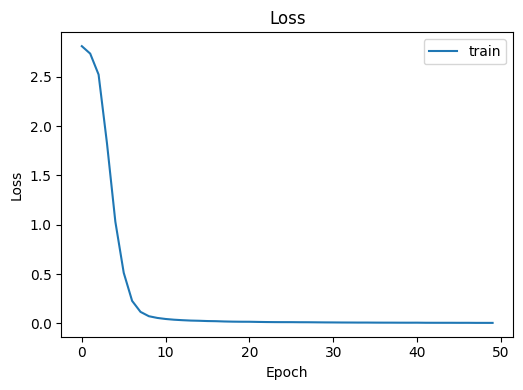

In [ ]:
plot_history_simple(history)

In [ ]:
type(history.history)

dict

In [ ]:
import csv

def save_history_csv(history, filename):
    """save history as csv file"""
    history_dict = history.history
    keys = history_dict.keys() # headers
    rows = zip(*history_dict.values())  # values

    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(keys)
        writer.writerows(rows)

history_filename = os.path.join(save_dir, f"{full_model_name}_history.csv")
save_history_csv(history, history_filename)